## Import necessary libraries

In [1]:
import os
from glob import glob
from tqdm.notebook import tqdm
import pickle

import math
import einops
import cv2
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing # for speed of feature extraction
import tensorflow as tf

## feature extractors
from scipy.stats import nakagami

## Define path of prepared data

In [2]:
saved_directory = "prepared_data"
saved_image_filename = "image_with_mask_label.pickle"
saved_nakagami_template = "nakagami_features_window_{}x{}.pickle"

os.makedirs(saved_directory, exist_ok=True)

## Load Data

In [3]:
with open(os.path.join(saved_directory, saved_image_filename), 'rb') as handle:
    data = pickle.load(handle)

In [4]:
N_labels = {
    'benign': 0,
    'malignant': 0,
    'normal': 0
}

for datum in data:
    label = datum["label"]
    if label == 0 :
        N_labels["benign"] += 1
    elif label == 1:
        N_labels["malignant"] += 1
    elif label ==2:
        N_labels["normal"] += 1
    else:
        raise ValueError('Label not valid!')

In [5]:
N_labels

{'benign': 437, 'malignant': 210, 'normal': 133}

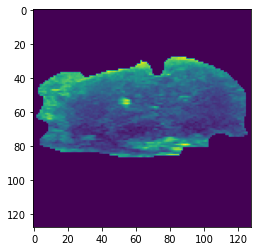

In [6]:
index = 437

plt.figure()
plt.imshow(data[index]["image"] * data[index]["mask"])

## Extract Nakagami map around Region of Interest (ROI)

In [7]:
def nakagami_estimation(samples):
    estimated_parameter = nakagami.fit(samples,
                                       loc=samples.mean(),
                                       scale=samples.var())
    return list(estimated_parameter)

In [ ]:
n_processes = 8
pool = multiprocessing.Pool(processes=n_processes)


window_size = (7,7)

nakagami_extracted_features = []
for counter, datum in enumerate(data[:(N_labels["benign"] + N_labels["malignant"])]): 
    print(f"File number: {counter}")
    
    columns = np.where(datum["mask"].sum(axis=0))[0]
    rows = np.where(datum["mask"].sum(axis=1))[0]
    
    
    rows = [max([0, rows[0] - window_size[0] // 2]), min([128, rows[-1] + window_size[0] // 2 + 1])]
    columns = [max([0, columns[0] - window_size[1] // 2]), min([128, columns[-1] + window_size[1] // 2 + 1])]
            
    
    image = datum["image"][rows[0] :rows[1] , columns[0]:columns[1]]
    mask = datum["mask"][rows[0] :rows[1] , columns[0]:columns[1]]
    
    
    windowed_image = tf.image.extract_patches(images=image[None, ..., None],
                                              sizes=[1, window_size[0], window_size[1], 1],
                                              strides=[1, 1, 1, 1],
                                              rates=[1, 1, 1, 1],
                                              padding='SAME')
    
    windowed_image = einops.rearrange(windowed_image,
                                      "b h w ws -> (b h w) ws ").numpy()
    
    estimated_parameters = []
    buffer = windowed_image.tolist()
    buffer = list(map(lambda x: np.array(x), buffer))
    for flag in tqdm( range( math.ceil( len(buffer) / n_processes) ) ):
        samples = buffer[flag * n_processes : (flag+1) * n_processes]

        estimated_parameters += pool.map(nakagami_estimation, samples)
        
        
    estimated_parameters = np.array(estimated_parameters)
    estimated_parameters = estimated_parameters.reshape((image.shape[0],image.shape[1],3))
    
    nakagami_extracted_features.append(estimated_parameters)

In [ ]:
saved_nakagami_filename = saved_nakagami_template.format(window_size[0], window_size[1])

with open(s.path.join(saved_directory, saved_nakagami_filename), 'wb') as handle:
    pickle.dump(nakagami_extracted_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Show a extracted nakagami map sample

In [16]:
with open(saved_nakagami_filename, 'rb') as handle:
    nakagami_extracted_features = pickle.load(handle)

In [13]:
len(nakagami_extracted_features)

647

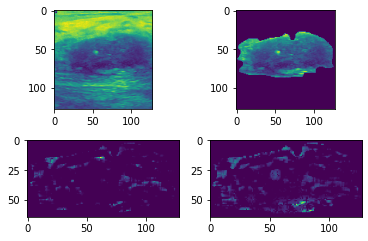

In [14]:
plt.subplot(2,2,1)
plt.imshow(data[index]["image"])
plt.subplot(2,2,2)
plt.imshow(data[index]["image"] * data[index]["mask"])


columns = np.where(data[index]["mask"].sum(axis=0))[0]
rows = np.where(data[index]["mask"].sum(axis=1))[0]
rows = [max([0, rows[0] - window_size[0] // 2]), min([128, rows[-1] + window_size[0] // 2 + 1])]
columns = [max([0, columns[0] - window_size[1] // 2]), min([128, columns[-1] + window_size[1] // 2 + 1])]
mask = data[index]["mask"][rows[0] :rows[1] , columns[0]:columns[1]]

plt.subplot(2,2,3)
plt.imshow(nakagami_extracted_features[index][..., 0] * mask)
plt.subplot(2,2,4)
plt.imshow(nakagami_extracted_features[index][..., 2] * mask)